# Research Question 9

9. What are the differences in outdoor recreational opportunities and environmental quality, such as air pollution levels and park accessibility?

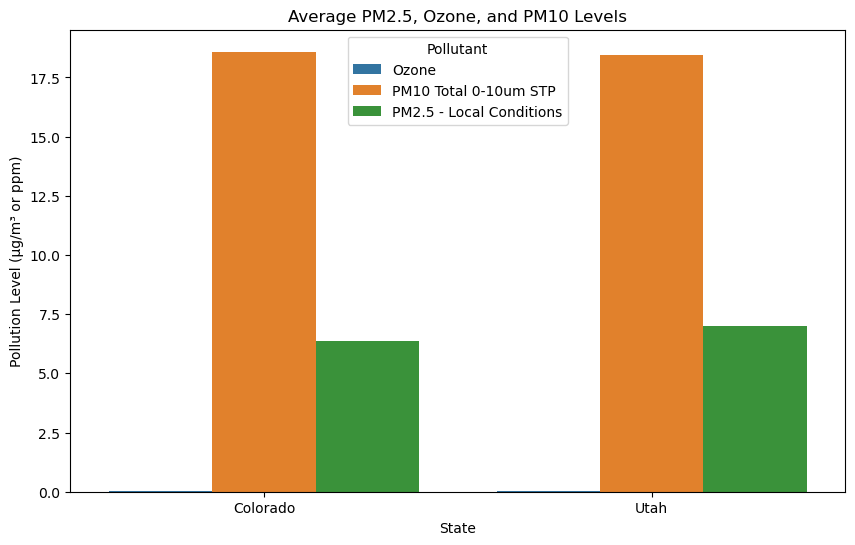

Saved Pollution Map to ../results/question_9/pollution_map.html
Saved National Parks Map to ../results/question_9/national_parks_map.html
Saved analysis results in ../results/question_9/


In [1]:
import os
from IPython.display import display
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Ensure results directory exists
output_dir = "../results/question_9"
os.makedirs(output_dir, exist_ok=True)

### 1. Fetch Air Pollution Data from EPA API ###
def get_air_quality_data(state_code):
    email = "taihei.sone.study.abroad@gmail.com"  # Required email
    key = "ecruswift59"
    param = "44201%2C81102%2C88101"  # Ozone, PM2.5, AQI
    bdate = "20230101"
    edate = "20231231"
    state = state_code
    
    url = f"https://aqs.epa.gov/data/api/dailyData/byState?email={email}&key={key}&param={param}&bdate={bdate}&edate={edate}&state={state}"
    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "Data" in data:
            # print(data["parameter_code"].unique())
            return data, pd.DataFrame(data["Data"])
        else:
            print(f"No air quality data available for {state_code}.")
            return None
    else:
        print(f"Error fetching air quality data for {state_code}. HTTP Status: {response.status_code}")
        return None

### 2. Fetch National Park Data from NPS API ###
def get_national_parks(state_code):
    api_key = "ux2NKshXwZ2twyeTnpAmwNfer4Qhwvg94mTALKBS"
    url = f"https://developer.nps.gov/api/v1/parks?stateCode={state_code}&api_key={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            parks = pd.DataFrame(data["data"])[["fullName", "latitude", "longitude", "designation", "description", "states"]]
            return data, parks[parks['states']==state_code]
        else:
            print(f"No park data available for {state_code}.")
            return None
    else:
        print(f"Error fetching park data for {state_code}. HTTP Status: {response.status_code}")
        return None

### 3. Process and Visualize Data ###
def analyze_and_visualize():
    # Fetch air pollution data
    before_air_quality_co, air_quality_co = get_air_quality_data("08")  # Colorado
    before_air_quality_ut, air_quality_ut = get_air_quality_data("49")  # Utah
    before_parks_co, parks_co = get_national_parks("CO")
    before_parks_ut, parks_ut = get_national_parks("UT")

    # Ensure air quality data is available
    if air_quality_co is not None and air_quality_ut is not None:
        air_quality_co["State"] = "Colorado"
        air_quality_ut["State"] = "Utah"
        air_quality = pd.concat([air_quality_co, air_quality_ut])

        # Group by state and parameter for comparison
        avg_pollution = air_quality.groupby(["State", "parameter"])["arithmetic_mean"].mean().reset_index()

        # Plot air pollution comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(x="State", y="arithmetic_mean", hue="parameter", data=avg_pollution)
        plt.title("Average PM2.5, Ozone, and PM10 Levels")
        plt.xlabel("State")
        plt.ylabel("Pollution Level (µg/m³ or ppm)")
        plt.legend(title="Pollutant")
        plt.savefig(f"{output_dir}/air_quality_comparison.png")
        plt.show()

        # Create map for pollution sites
        map_pollution = folium.Map(location=[39.5, -106.0], zoom_start=6)

        avg_site_pollution = air_quality.groupby(["site_number", 'latitude', 'longitude', 'parameter'])["arithmetic_mean"].mean().reset_index()
        for _, row in avg_site_pollution.iterrows():
            folium.CircleMarker(
                location=[row["latitude"], row["longitude"]],
                radius=max(3, row["arithmetic_mean"] * 2),  # Adjust size dynamically
                color="blue" if row["parameter"] == "Ozone" else "green" if row["parameter"] == "PM2.5 - Local Conditions" else "orange",
                fill=True,
                fill_color="blue" if row["parameter"] == "Ozone" else "green" if row["parameter"] == "PM2.5 - Local Conditions" else "orange",
                fill_opacity=0.7,
                popup=f"{row['parameter']}: {row['arithmetic_mean']:.2f} µg/m³",
            ).add_to(map_pollution)

        map_pollution.save(f"{output_dir}/pollution_map.html")
        print(f"Saved Pollution Map to {output_dir}/pollution_map.html")

    # Ensure parks data is available before processing
    if parks_co is not None and parks_ut is not None:
        map_parks = folium.Map(location=[39.5, -106.0], zoom_start=6)

        for _, row in parks_co.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=row["fullName"],
                icon=folium.Icon(color="green", icon="tree"),
            ).add_to(map_parks)

        for _, row in parks_ut.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=row["fullName"],
                icon=folium.Icon(color="blue", icon="tree"),
            ).add_to(map_parks)

        map_parks.save(f"{output_dir}/national_parks_map.html")
        print(f"Saved National Parks Map to {output_dir}/national_parks_map.html")

    print(f"Saved analysis results in {output_dir}/")

    return before_air_quality_co, before_air_quality_ut, air_quality_co, air_quality_ut, before_parks_co, before_parks_ut, parks_co, parks_ut

# Run Analysis
before_air_quality_co, before_air_quality_ut, air_quality_co, air_quality_ut, before_parks_co, before_parks_ut, parks_co, parks_ut = analyze_and_visualize()

## Before and After Snapshots of the Dataset

In [2]:
# before air quality in Colorado
pd.DataFrame(before_air_quality_co['Data']).head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12


In [3]:
# before air quality in utah
pd.DataFrame(before_air_quality_ut['Data']).head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17


In [4]:
# after air quality in Colorado
air_quality_co.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change,State
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado


In [5]:
# after air quality in utah
air_quality_ut.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change,State
0,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
1,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
2,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
3,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
4,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah


In [7]:
# before national park in Colorado
pd.DataFrame(before_parks_co['data']).head()

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0


In [8]:
# before national park in Utah
pd.DataFrame(before_parks_ut['data']).head()

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0


In [9]:
# after national park in Colorado
parks_co.head()

,fullName,latitude,longitude,designation,description,states
0,Amache National Historic Site,38.04962,-102.32903,National Historic Site,"Amache, also known as the Granada Relocation C...",CO
1,Bent's Old Fort National Historic Site,38.03977546,-103.4266499,National Historic Site,In the 1840s the Arkansas River was the border...,CO
2,Black Canyon Of The Gunnison National Park,38.57779869,-107.7242756,National Park,"Big enough to be overwhelming, yet still intim...",CO
4,Colorado National Monument,39.05045016,-108.6920709,National Monument,Colorado National Monument preserves one of th...,CO
5,Curecanti National Recreation Area,38.46584558,-107.3303371,National Recreation Area,Three reservoirs and surrounding lands make up...,CO


In [10]:
# after national park in Utah
parks_ut.head()

,fullName,latitude,longitude,designation,description,states
0,Arches National Park,38.72261844,-109.5863666,National Park,"Discover a landscape of contrasting colors, la...",UT
1,Bryce Canyon National Park,37.58399144,-112.1826689,National Park,Hoodoos (irregular columns of rock) exist on e...,UT
3,Canyonlands National Park,38.24555783,-109.8801624,National Park,Canyonlands invites you to explore a wildernes...,UT
4,Capitol Reef National Park,38.2821653131,-111.247048378,National Park,Located in south-central Utah in the heart of ...,UT
5,Cedar Breaks National Monument,37.63545562,-112.845268,National Monument,"Crowning the Grand Staircase, Cedar Breaks sit...",UT
